In [1]:
path = "/home/perplexity/Desktop/GitHub/python_anes/anes_timeseries_cdf_csv_20220916/"

In [2]:
with open(path + "format_map.txt", "r") as f:
    # read the entire file in as a single line
    data = f.read()
    # split on any number of white spaces of any kind
    data = data.split()[2:-1]

for i, token in enumerate(data):
    if i%2==0 and "." in token:
        print(f"{i}: {token}")
    elif i%2==1 and "." not in token:
        print(f"{i}: {token}") # seems to check out

fields = [data[i] for i in range(0, len(data), 2)]
formats = [data[i].replace(".","") for i in range(1, len(data), 2)]
format_map = dict(zip(fields, formats))

In [3]:
with open(path + "labels.txt", "r") as f:
    # list of lines
    labels = f.readlines()[1:]

labels = [labels.split(" = ") for labels in labels]
labels = [[item.strip().replace('"','') for item in label] for label in labels]
labels_map = dict(labels)

In [4]:
with open(path + "proc_format.txt", "r") as f:
    data = f.readlines()[1:]

data
format_vals = {}
# looks lke a job for a state machine
key = None
for i, line in enumerate(data):
    line = line.strip()
    if line.startswith("value"):
        key = line.split()[1]
        format_vals[key] = {}
    else:
        line = line.split(" = ")
        val = int(line[0].strip())
        label = line[1].replace(";","").strip().replace("'",'')
        format_vals[key][val] = label

In [5]:
with open(path + "missings.txt", "r") as f:
    data = f.readlines()
# The various types of missing values are listed in the formats anyway, so this is basically redundant, assuming that I'm going to use the formats to interpret the data.

In [6]:
path = "/home/perplexity/Desktop/GitHub/python_anes/anes_timeseries_cdf_csv_20220916/"
fname = "anes_timeseries_cdf_csv_20220916.csv"
import pandas as pd
import matplotlib.pyplot as plt
col_names = pd.read_csv(path + fname, nrows=0).columns
dtypes = {"Version": str, "VCF0004": int, "VCF0900c": str, "VCF0901b": str}
for col in col_names:
    if col not in dtypes:
        dtypes[col] = "Float64" # is there a reason we did floats instead of ints?  I guess the weights are floats; are all the rest ints?
        
anes = pd.read_csv(path + fname, dtype=dtypes, na_values=["", " "])

In [17]:
# Okay, so I think now I want to do an actual analysis.
# So for that, I think we build a copy/subset/recode of the data, and then we can do some analysis on that.
# But first, let's talk about the purpose of this analysis:
    # The basic question is whether there is any detectable way in which Republicans became more racist after 2012.
    # The measures of racism we could use would generally be the 4-item resentment scale, some race-adjacent policies involving crime and immigration, and any explicitly racist attitudes.
    # The measures of Republicanism could include party ID, presidential vote, and self-rated conservatism.
    # We would want to restrict our analysis to white respondents for most items, though for the race-adajcent policies we might want to include all respondents in a side analysis.


gop_resent = anes.copy()
def calculate_resentment(row):
    if pd.isna(row["VCF9039"]) or pd.isna(row["VCF9040"]) or pd.isna(row["VCF9041"]) or pd.isna(row["VCF9042"]):
        return pd.NA
    elif row["VCF9039"] in (8,9) or row["VCF9040"] in (8,9) or row["VCF9041"] in (8,9) or row["VCF9042"] in (8,9):
        return pd.NA
    else:
        return row["VCF9039"] + row["VCF9042"] - row["VCF9040"] - row["VCF9041"]

def get_race(row):
    if pd.isna(row["VCF0105a"]):
        return pd.NA
    elif row["VCF0105a"] == 1:
        return "White"
    elif row["VCF0105a"] == 2:
        return "Black"
    elif row["VCF0105a"] == 5:
        return "Hispanic"
    elif row["VCF0105a"] in (3,4,6,7):
        return "Other"
    else:
        return pd.NA

gop_resent = gop_resent[gop_resent["VCF0004"] >= 2000]
gop_resent = gop_resent[gop_resent["VCF0004"]%4 == 0]
gop_resent.rename(columns={
    "VCF0004": "year",
    "VCF0009z": "weight",
    #"VCF9999": "weight",
}, inplace=True)
gop_resent["resentment"] = gop_resent.apply(calculate_resentment, axis=1)
gop_resent["race"] = gop_resent.apply(get_race, axis=1)
gop_resent["strong_republican"] = gop_resent["VCF0301"].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 0: pd.NA})
gop_resent["republican"] = gop_resent["VCF0301"].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 0: pd.NA})
gop_resent["democrat"] = gop_resent["VCF0301"].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 0: pd.NA})
gop_resent["lean_republican"] = gop_resent["VCF0301"].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 0: pd.NA})
gop_resent["conservative"] = gop_resent["VCF0803"].replace({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 0: pd.NA})
gop_resent["vote_rep_prez"] = gop_resent["VCF0704a"].replace({1: 0, 2: 1, 0: pd.NA})
gop_resent["blacks_lazy"] = gop_resent["VCF9271"].replace({-8: pd.NA, -9: pd.NA})
gop_resent["therm_blacks"] = gop_resent["VCF0206"].replace({98: pd.NA, 99: pd.NA})
gop_resent["therm_whites"] = gop_resent["VCF0207"].replace({98: pd.NA, 99: pd.NA})
gop_resent["therm_police"] = gop_resent["VCF0214"].replace({98: pd.NA, 99: pd.NA})
gop_resent["therm_delta"] = gop_resent["therm_whites"] - gop_resent["therm_blacks"]
gop_resent["prev_rep_prez"] = gop_resent["VCF9027"].replace({1: 0, 2: 1, 0:pd.NA, 3: pd.NA, 5: pd.NA, 9: pd.NA})
gop_resent["party3"] = gop_resent["VCF0301"].apply(lambda x: "D" if x in [1, 2] else "I" if x in [3, 4, 5] else "R" if x in [6, 7] else None)
gop_resent["party3a"] = gop_resent["VCF0301"].apply(lambda x: "D" if x in [1, 2, 3] else "I" if x in [4] else "R" if x in [5, 6, 7] else None)
gop_resent["antiimm"] = gop_resent["VCF0879"].replace({8: pd.NA, 9: pd.NA})
gop_resent["college"] = gop_resent["VCF0110"].replace({4: 1, 0: pd.NA, 1: 0, 2: 0, 3:0})
gop_resent["noguarjobs"] = gop_resent["VCF0809"].replace({0: pd.NA, 9: pd.NA})
def group5(row):
    # if it is null, return None
    if pd.isnull(row["race"]):
        return None
    if row["race"] == "White":
        if pd.isnull(row["college"]):
            return None
        if row["college"] == 1:
            return "WhiteC"
        elif row["college"] == 0:
            return "WhiteN"
        else:
            return None
    else:
        return row["race"]

gop_resent["group5"] = gop_resent.apply(group5, axis=1)

def group5a(row):
    # if it is null, return None
    if pd.isnull(row["race"]):
        return None
    if row["race"] == "White":
        if pd.isnull(row["republican"]):
            return "WhiteO"
        elif row["republican"] == 1:
            return "WhiteR"
        if pd.isnull(row["democrat"]):
            return "WhiteO"
        elif row["democrat"] == 1:
            return "WhiteD"
        return "WhiteO"
        
    else:
        return row["race"]

gop_resent["group5a"] = gop_resent.apply(group5a, axis=1)
gop_resent["vote_prev_vote"] = pd.NA
gop_resent.loc[(gop_resent["prev_rep_prez"] == 1) & (gop_resent["vote_rep_prez"] == 1), "vote_prev_vote"] = "Rep-Rep"
gop_resent.loc[(gop_resent["prev_rep_prez"] == 1) & (gop_resent["vote_rep_prez"] == 0), "vote_prev_vote"] = "Rep-Dem"
gop_resent.loc[(gop_resent["prev_rep_prez"] == 0) & (gop_resent["vote_rep_prez"] == 1), "vote_prev_vote"] = "Dem-Rep"
gop_resent.loc[(gop_resent["prev_rep_prez"] == 0) & (gop_resent["vote_rep_prez"] == 0), "vote_prev_vote"] = "Dem-Dem"

# The "trust" thing is kind of a mess; it cuts over from VCF0619, a two-value item, to VCF9244, a five-value item, in 2008, with the 2008 sample being split in half.
gop_resent["distrust"] = gop_resent["VCF9244"].replace({-8: pd.NA, -9: pd.NA})

def weighted_mean(row, val_col, weight_col):
    nomiss = row[row[val_col].notna()]
    return (nomiss[val_col] * nomiss[weight_col]).sum() / nomiss[weight_col].sum()


In [12]:
gop_resent["noguarjobs"].value_counts()

noguarjobs
4.0    4141
5.0    3031
6.0    2912
7.0    2778
3.0    2594
1.0    2280
2.0    1871
Name: count, dtype: Int64

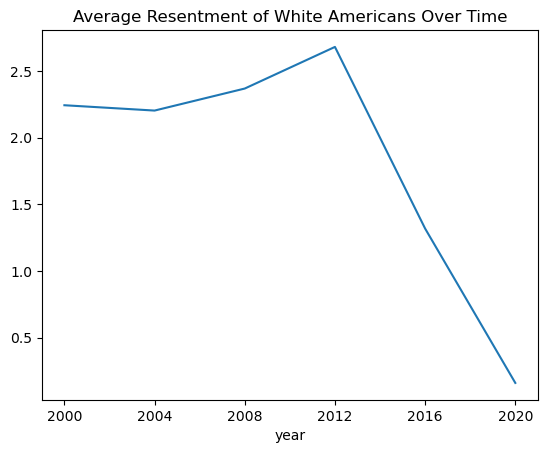

In [30]:
# Average Resentment of White Americans Over Time
# (No interesting differences were seen with "strong" or "lean" republicans)
subset = gop_resent
subset = subset[subset["race"] == "White"]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of White Americans Over Time")

plt.xticks(subset["year"].unique())
plt.show()
# An interesting thought - I can see how seeing Obama in office might skew the scale
# ...it might make someone less likely to believe black people are being discriminated against, without necessarily indicating more resentment.
# This could explain the slight increase in overall resentment, but not the larger increase among Republicans.

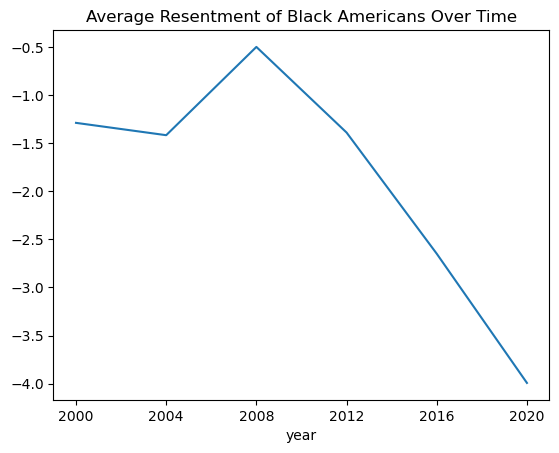

In [ ]:
# I just thought of one way to shine some light on that...
subset = gop_resent
subset = subset[subset["race"] == "Black"]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of Black Americans Over Time")

plt.xticks(subset["year"].unique())
plt.show()
# So that's interesting...you actually do see very similar patterns, but with the peak in 2008 instead of 2012
# Note that while this begins lower than white Democrats, it ends at the same level.

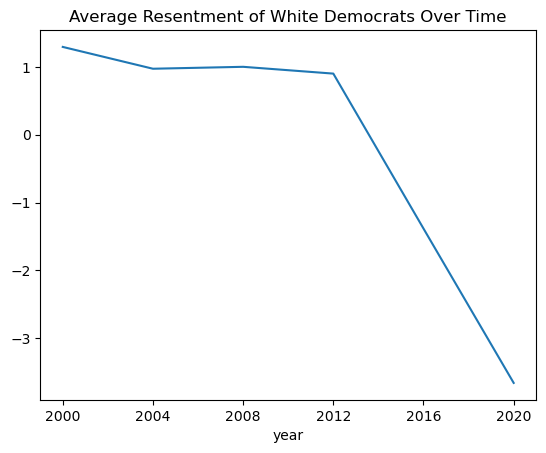

In [ ]:
# Average Resentment of White Democrats Over Time
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["democrat"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of White Democrats Over Time")

plt.xticks(subset["year"].unique())
plt.show()

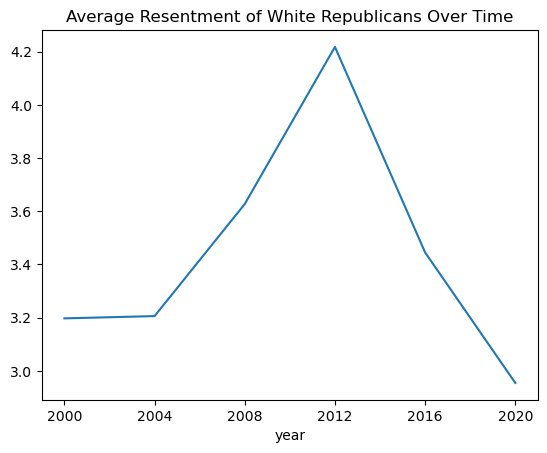

In [ ]:
# Average Resentment of White Republicans Over Time
# (No interesting differences were seen with "strong" or "lean" republicans)
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["republican"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of White Republicans Over Time")

plt.xticks(subset["year"].unique())
plt.show()

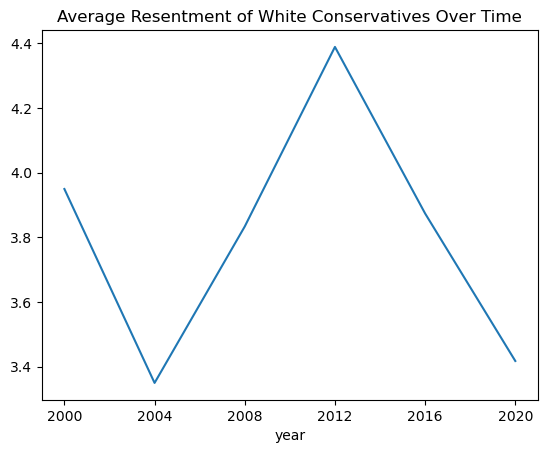

In [ ]:
# Average Resentment of White Conservatives Over Time
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["conservative"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of White Conservatives Over Time")

plt.xticks(subset["year"].unique())
plt.show()
# This shows a similar pattern, but it's slightly different in that by 2020 it has not quite regained its 2004 low.

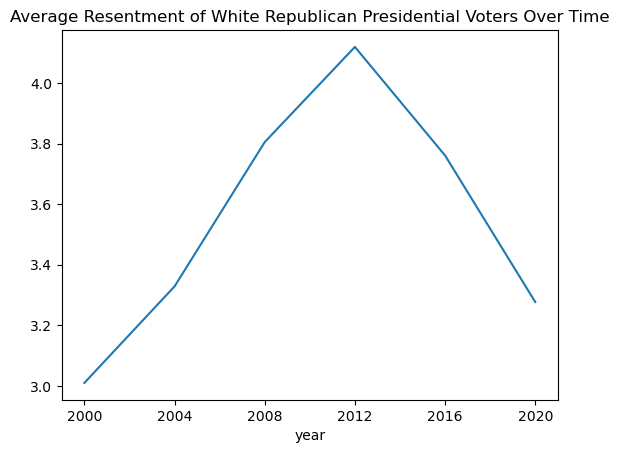

In [ ]:
# Average Resentment of White Republican Presidential Voters Over Time
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["vote_rep_prez"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "resentment", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Resentment of White Republican Presidential Voters Over Time")

plt.xticks(subset["year"].unique())
plt.show() # again a fairly similar pattern, with slightly lower values in 2000 this time.  Maybe shouldn't dwell on that, given that the difference is small and I'm doing multiple comparisons.

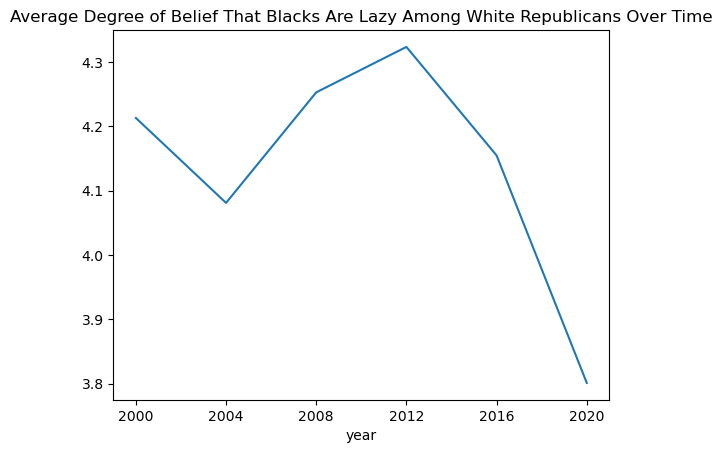

In [ ]:
# Average Degree of Belief That Blacks Are Lazy Among White Republicans Over Time

subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["republican"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "blacks_lazy", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Degree of Belief That Blacks Are Lazy Among White Republicans Over Time")

plt.xticks(subset["year"].unique())
plt.show()
# Again we see kind of a similar pattern, but more subdued, and with the rapid decline not happening until 2020, and the initial average is near the middle

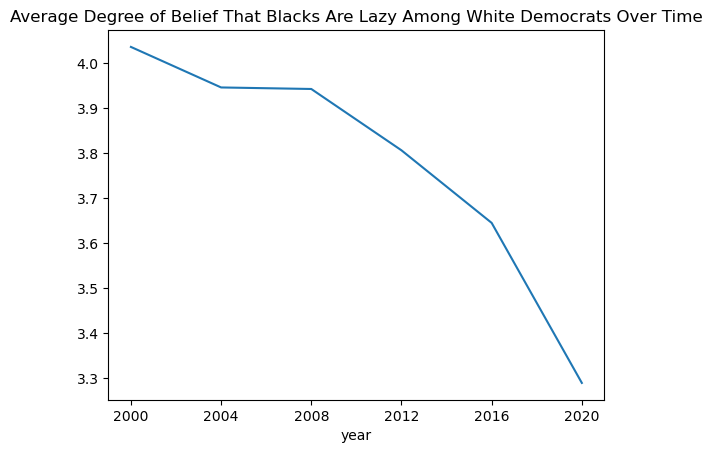

In [ ]:
# Average Degree of Belief That Blacks Are Lazy Among White Democrats Over Time

subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["democrat"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "blacks_lazy", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Degree of Belief That Blacks Are Lazy Among White Democrats Over Time")

plt.xticks(subset["year"].unique())
plt.show()
# At this point I'm less certain that there is even a 

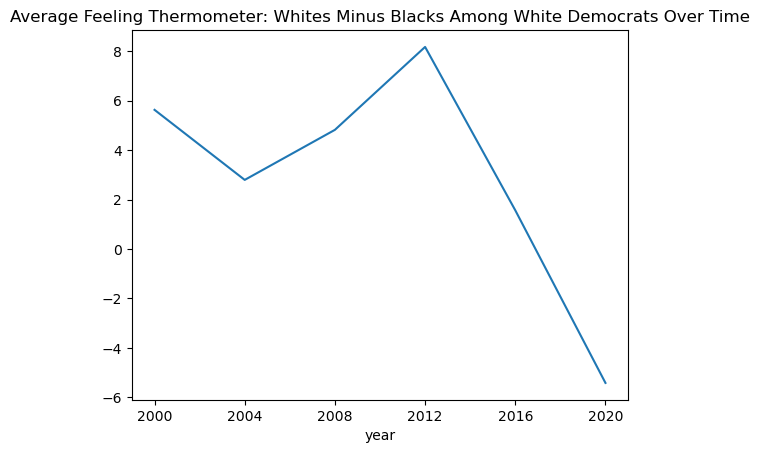

In [ ]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["democrat"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "therm_delta", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Feeling Thermometer: Whites Minus Blacks Among White Democrats Over Time")

plt.xticks(subset["year"].unique())
plt.show() 

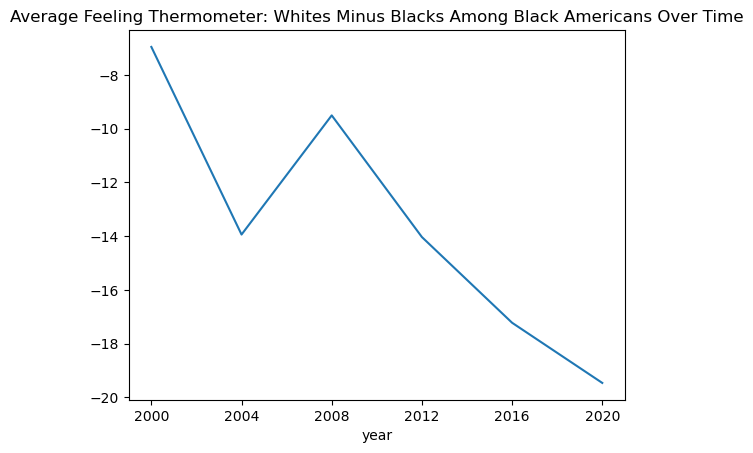

In [ ]:
subset = gop_resent
subset = subset[subset["race"] == "Black"]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "therm_delta", "weight").plot()
# now the same thing, but with only the occuring year values on the x-axis
plt.title("Average Feeling Thermometer: Whites Minus Blacks Among Black Americans Over Time")

plt.xticks(subset["year"].unique())
plt.show() # This interestingly seems to show black people liking white people less and less over time, with a slip reversal in 2008 only...again, a little hard to interpret in light of other thingss

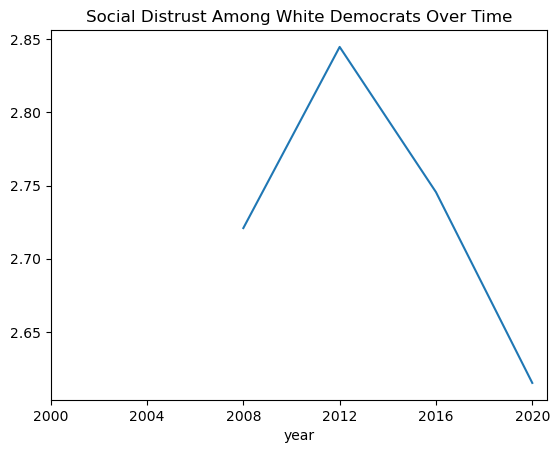

In [ ]:
# Social Distrust Among White Democrats Over Time

subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["democrat"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "distrust", "weight").plot()
plt.title("Social Distrust Among White Democrats Over Time")

plt.xticks(subset["year"].unique())
plt.show()

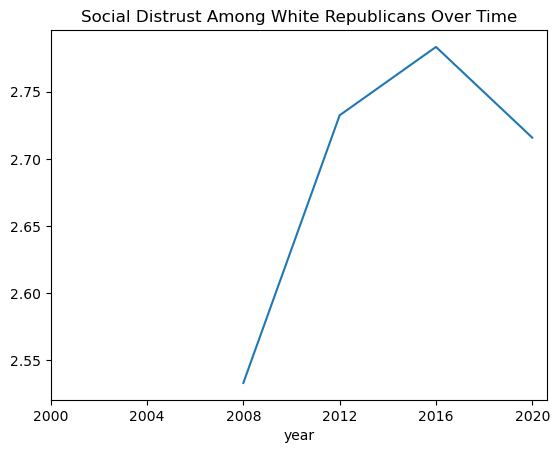

In [32]:
# Social Distrust Among White Republicans Over Time

subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["republican"] == 1]
# do a line graph of resentment over time
subset.groupby("year").apply(weighted_mean, "distrust", "weight").plot()
plt.title("Social Distrust Among White Republicans Over Time")

plt.xticks(subset["year"].unique())
plt.show()

<Axes: xlabel='vote_prev_vote'>

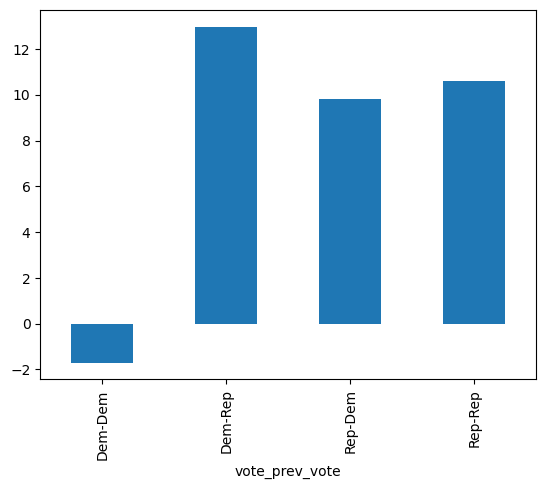

In [ ]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["year"] == 2016]
subset.groupby("vote_prev_vote").apply(weighted_mean, "therm_delta", "weight").plot(kind="bar")
# Okay, so here for the first time we see signs of racial resentment specifically among Obama/Trump voters.
# There is, however, another interpretation, which is that Obama/Trump voters simply didn't join the Great Awokening like Obama/Clinton voters did.
# There's a weird thing though, where we see the pattern even more dramatically in 2020...what does that even mean?
# I think it means Trump didn't change, but Democrats who stuck through voting for both Clinton and Biden were well into the negatives for White Minus Black; i.e. the Great Awokening.

<Axes: xlabel='vote_prev_vote'>

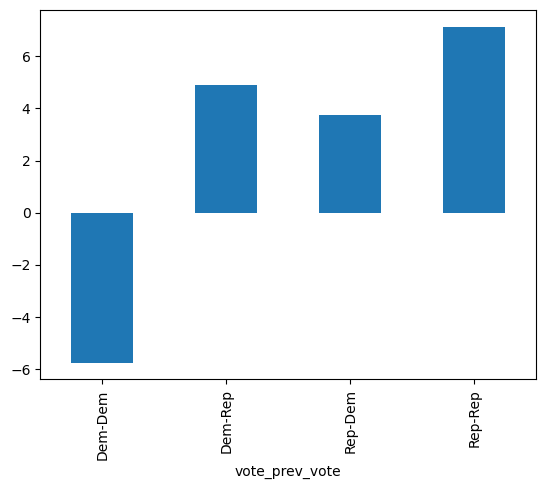

In [ ]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
subset = subset[subset["year"] == 2020]
subset.groupby("vote_prev_vote").apply(weighted_mean, "therm_delta", "weight").plot(kind="bar")
# This to me looks like the Great Awokening among white Democrats, and a...actually, similar magnitude of Great Awokening among white Republicans, just from a lower (higher) starting point.

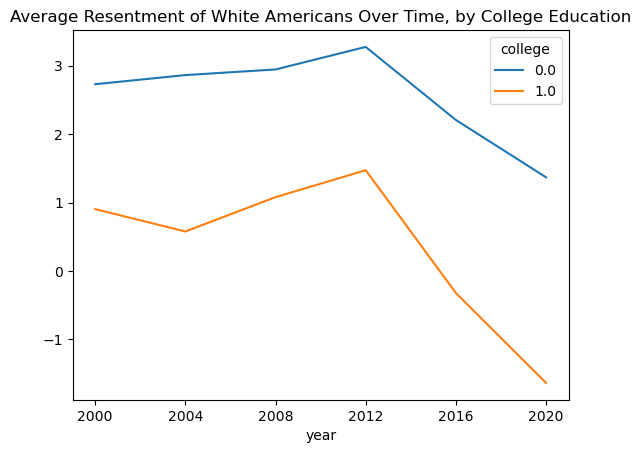

In [20]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
# For this one, do two line graphs of resentment, one for college, one for non-college
subset.groupby(["year", "college"]).apply(weighted_mean, "resentment", "weight").unstack().plot()
plt.title("Average Resentment of White Americans Over Time, by College Education")

plt.xticks(subset["year"].unique())
plt.show()


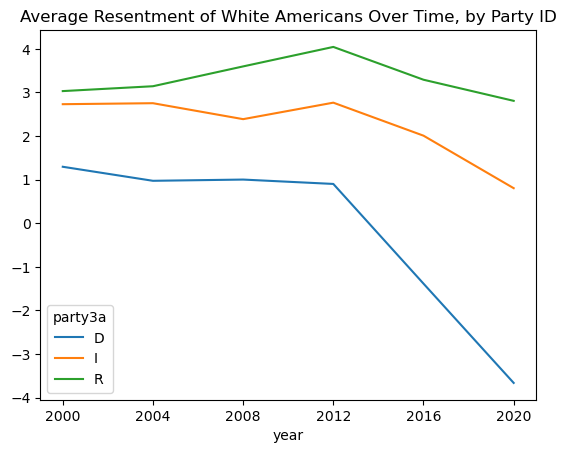

In [27]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
# For this one, do two line graphs of resentment, one for college, one for non-college
subset.groupby(["year", "party3a"]).apply(weighted_mean, "resentment", "weight").unstack().plot()
plt.title("Average Resentment of White Americans Over Time, by Party ID")

plt.xticks(subset["year"].unique())
plt.show()

/tmp/ipykernel_9751/1429774128.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset.groupby(["year", "party3a"]).apply(weighted_mean, "noguarjobs", "weight").unstack().plot()


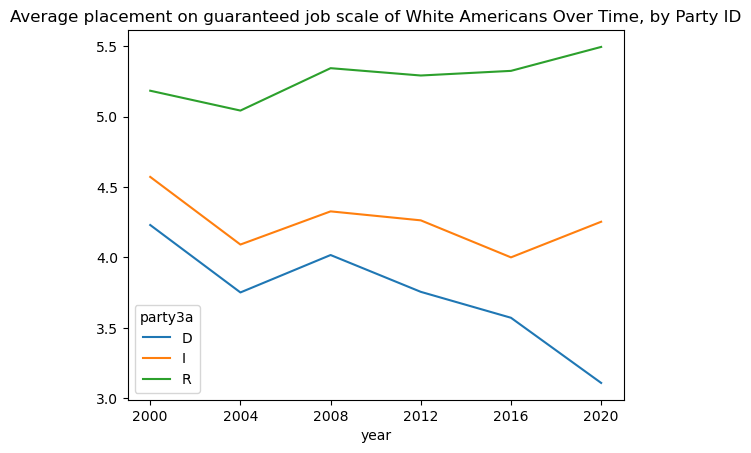

In [18]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
# For this one, do two line graphs of resentment, one for college, one for non-college
subset.groupby(["year", "party3a"]).apply(weighted_mean, "noguarjobs", "weight").unstack().plot()
plt.title("Average placement on guaranteed job scale of White Americans Over Time, by Party ID")

plt.xticks(subset["year"].unique())
plt.show()

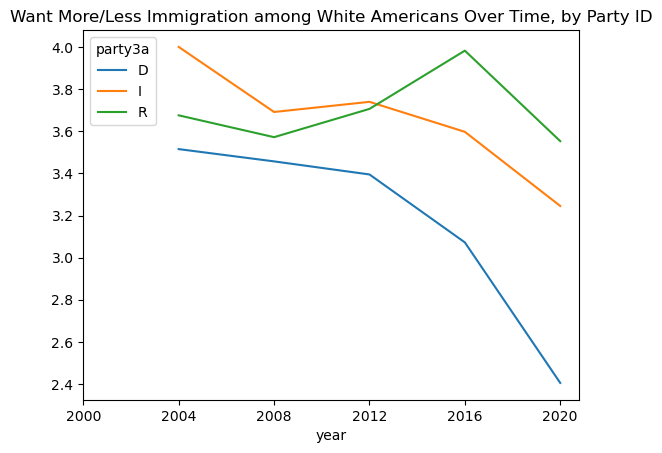

In [43]:
subset = gop_resent
subset = subset[subset["race"] == "White"]
# For this one, do two line graphs of resentment, one for college, one for non-college
subset.groupby(["year", "party3a"]).apply(weighted_mean, "antiimm", "weight").unstack().plot()
plt.title("Want More/Less Immigration among White Americans Over Time, by Party ID")

plt.xticks(subset["year"].unique())
plt.show()

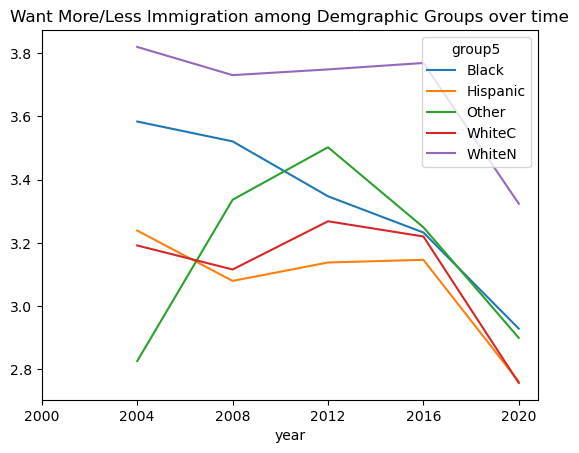

In [ ]:
subset = gop_resent
# For this one, do two line graphs of resentment, one for college, one for non-college
subset.groupby(["year", "group5"]).apply(weighted_mean, "antiimm", "weight").unstack().plot()
plt.title("Want More/Less Immigration over time, by demographic group")

plt.xticks(subset["year"].unique())
plt.show()

<Axes: xlabel='group5a'>

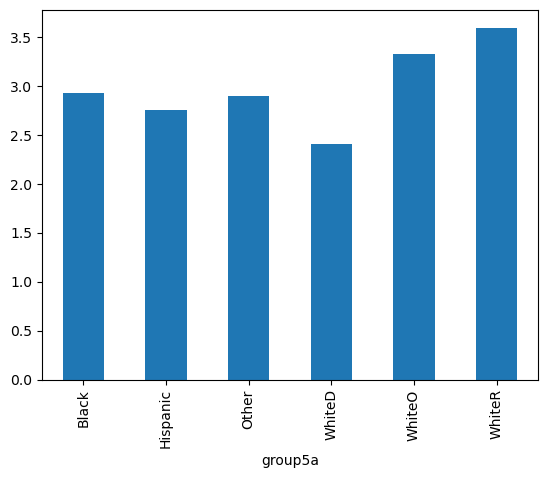

In [77]:
subset = gop_resent
subset = subset[subset["year"] == 2020]
subset.groupby("group5a").apply(weighted_mean, "antiimm", "weight").plot(kind="bar")